In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tskit
import msprime
import sparg

/Users/mmosmond/.virtualenvs/allsparg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Simple Two Samples

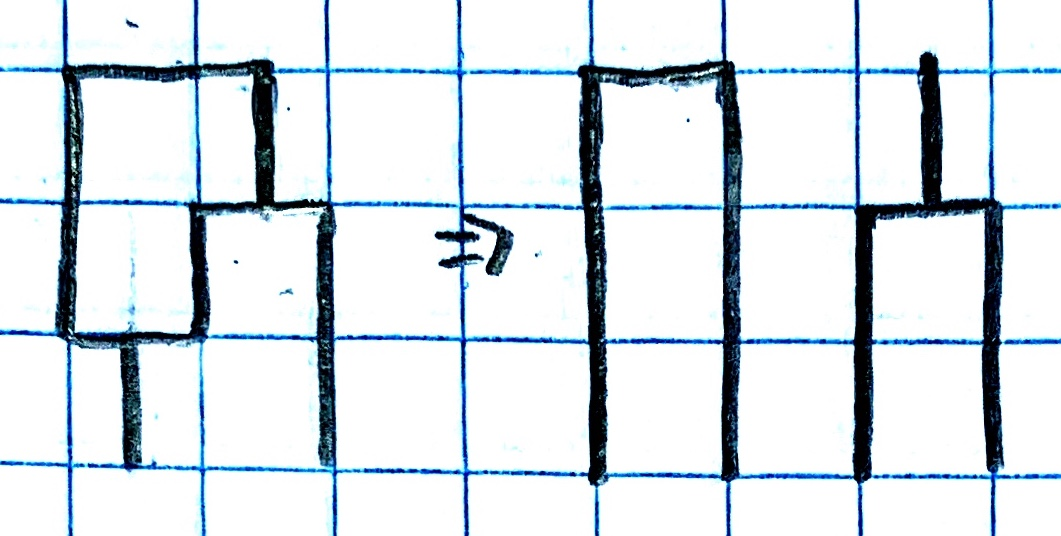

In [3]:
# mmo: just making some notes so that i understand what you're doing
# so here you have an entry for each path up each marginal tree, starting with the leftmost path of the leftmost tree and iterating over paths then trees 
ra = np.array([
    [3,0,1,0], #eg, the leftmost path of the leftmost tree shares all 3 time units with itself, 0 with the rightmost path of the leftmost tree, 1 with the leftmost path of the rightmost tree, and 0 with the rightmost path of the rightmost tree
    [0,3,1,3],
    [1,1,3,1],
    [0,3,1,3]
])
new_order = [0, 1, 2] #now you drop the last path as you've used it twice (it is in both trees)
ra = ra[:, new_order][new_order]

locations = np.array([ #giving locations for each path, not sample
    [-4],
    [4],
    [-4]
])

In [4]:
def cond_mvn(locations, mean_1, mean_2, sigma_11, sigma_22):
    '''mean and variance of ancestor locations from multivariate normal conditioned on lcoations of samples, see https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions'''
    # note the change in notation from wikipedia: here sigma_11 has replaced sigma_12, the covariance between the two partitions
    u = mean_1 + np.dot(np.dot(sigma_11, np.linalg.inv(sigma_22)),locations - mean_2) #expected locations of ancestors given their samples locations, mean locations (mean_1=mean_2), and shared times (sigma_22), as well as the shared times between each ancestor and the sample lineages (sigma_11)
    sigma = sigma_11 - np.dot(np.dot(sigma_11, np.linalg.inv(sigma_22)), sigma_11) #variance in location of ancestors (not that this does not match the formula on wikipedia: there we need the covariance amongst the ancestors as well as the transpose of what is sigma_11 here; but this is not used in the code below anyway...)
    return u, sigma

def calc_cmvn(df, cov_mat, sample_locs):
    a = df["t"] #time since MRCA
    if a > 2:
        b = a - 2 #shared time of ancestor on path 1 with path 3
    else:
        b = 0
    if a < 1:
        c = a #shared time of ancestor on path 2 with path 3
    else:
        c = 1
    sigma_11 = np.array([
        [a,0,b], #note paths 1 and 2 do not share time
        [0,a,c],
        [b,c,a]
    ])
#     u1 = np.array([np.mean(sample_locs[0:2])]) #mean locations of samples (this is what James had, and I switched it to the MLE below)
    k = len(cov_mat)
    Tinv = np.linalg.pinv(cov_mat)
    a1 = np.matmul(np.matmul(np.ones(k), Tinv), np.ones(k).reshape(-1,1))
    a2 = np.matmul(np.matmul(np.ones(k), Tinv), sample_locs)
    u1 = a2/a1 
    u2 = np.array([u1]*cov_mat.shape[0]) #just expanded to be same length as locations
    expectation, variance = cond_mvn(
        locations=sample_locs,
        sigma_11=sigma_11,
        sigma_22=cov_mat,
        mean_1=u1,
        mean_2=u2
    )
    positions = np.transpose(expectation)[0] #just formatting
    for p in range(len(positions)):
        df["A"+str(p)] = positions[p] #position of ancestor p
    return df

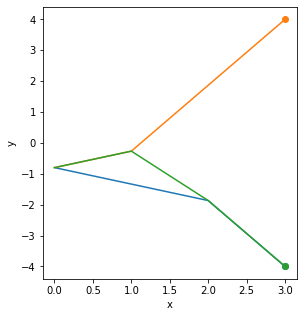

In [5]:
timeseries = pd.DataFrame(data=np.arange(3, -0.5, -0.5), columns=["t"]) #times since MRCA
timeseries = timeseries.apply(calc_cmvn, axis=1, cov_mat=ra, sample_locs=locations) #expected ancestor locations over all times

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
for lineage in range(len(timeseries.columns)-1):
    ax1.scatter(timeseries["t"][0], timeseries["A"+str(lineage)][0]) #sample locations
    ax1.plot(timeseries["t"], timeseries["A"+str(lineage)]) #ancestor locations

ax1.set_xlabel('x')
ax1.set_ylabel('y')

plt.show()

The above is what I had previously done as well -- finding the shared times between each unique path up an ARG and using that as the covariance matrix in the same conditional multivariate normal approach.

While the plots look sensible, I have two concerns about this approach.

First, the number of unique paths is going to explode with more samples.

Second, I'm not sure we get the correct estimates of dispersal and ancestor locations this way.

I think I have an idea that fixes both concerns. That is to find the covariance between each sample location using the properties of Brownian bridges for the loops. I don't have an algorithm yet, but for a particular (and simple) ARG I can work up the tree.

Here is how it works in the ARG above. We have two samples, the green (0) and the orange (1). Following the labeling of tskit, give the recombination point two nodes, node 2 on the left and node 3 on the right, the next internal node node 4, and the GMRCA node 5. The length of a branch above node i is ti.

We start at one sample, say node 0. The variance in that location is the time to the parent node (node 2/3), t0, plus the variance in the location of the parent node. The variance in the location of node 2 is a little trickier, since it is part of a loop. But the key insight is that we can "open" that loop up at the top (here at node 5), so that we have a Brownian bridge from the location of node 5 back to itself, with the three internal nodes (2, 3 and 4) along it. The variance in the location of node 2 is then (https://en.wikipedia.org/wiki/Brownian_bridge) t2(t3+t4)/(2 t2) = t2/2. This makes some intuitive sense, because we have two trees giving us information about this node, the variance is smaller than if we had only one tree (t2). So the variance in the location of the sample node 0 is t2/2 + t0. This is 2/2+1 = 2 in the example above.

For the orange sample, node 1, the variance in its location is the length of the branch from it to node 4, t1, plus the variance in the location of node 4, which, by the same Brownian bridge logic, is t4(t2+t3)/(2 t2). Summing these together in the example above we get 2 + 1(2+1)/4 = 11/4. There is more variance in the location of node 0 than node 1 because node 1 left the loop earlier, so less info about it is shared across the trees. There is a bit less variance in the location of node 1 then if we had only one tree (2 + 1 = 3).

The covariance between the locations of nodes 0 and 1 is determined by the covariance in the locations of nodes 3 and 4. Again opening the loop at the GMRCA, the covariance between these two locations follows from the properties of a Brownian bridge, being t2 t4 / (2 t2) = t4/2. Here 1/2. This happens to be the average of the covariance in the two trees, 0 and 1.

To summarize:

The covariance matrices for the two trees are [[3,0],[0,3]] and [[3,1],[1,3]]. 

The covariance matrix for the ARG using Brownian bridges is [[2,1/2],[1/2,11/4]].

And your unique-paths covariance matrix for the ARG is [[3,0,1],[0,3,1],[1,1,3]].

Before locating ancestors let's try inferring the dispersal rate with these three approaches.

In [6]:
def mle_dispersal(sigma_11, locs):
    '''
    MLE dispersal estimate
    
    parameters
    ----------
    sigma_11: covariance matrix among sample locations
    locs: sample locations
    '''
    
    k = len(sigma_11) #number of samples
    Tinv = np.linalg.pinv(sigma_11) #inverse of covariance matrix among sample locations
    
    # find MLE MRCA location (eqn 5.6 Harmon book)
    a1 = np.matmul(np.matmul(np.ones(k), Tinv), np.ones(k).reshape(-1,1))
    a2 = np.matmul(np.matmul(np.ones(k), Tinv), locs)
    ahat = a2/a1
    
    # find MLE dispersal rate (eqn 5.7 Harmon book)
    x = locs.reshape(-1,1) #make locations a column vector
    R1 = x - ahat * np.ones(k).reshape(-1,1)
    Rhat = np.matmul(np.matmul(np.transpose(R1), Tinv), R1) / (k-1)
    
    return Rhat[0]

From our two trees we get

In [7]:
mle_dispersal(sigma_11=[[3,0],[0,3]], locs=np.array([0,1]))

array([0.16666667])

and

In [8]:
mle_dispersal(sigma_11=[[3,1],[1,3]], locs=np.array([0,1]))

array([0.25])

While from the Brownian bridges ARG we get

In [9]:
mle_dispersal(sigma_11=[[2,1/2],[1/2,11/4]], locs=np.array([0,1]))

array([0.26666667])

And from your unique paths approach we get

In [10]:
mle_dispersal(sigma_11=ra, locs=np.array([0,1,0]))

array([0.13333333])

Note that yours is exactly 1/2 of ours, which is caused by the denominator in the final equation, k-1, which is 1 in our case and 2 in yours. So perhaps k should be the number of samples, not rows of the covariance matrix? We should try a few more examples to see. (See the next handmade ARG below, where we show this was a coincidence.)

To locate ancestors we also need to calculate the covariance between ancestor locations and sample locations. We can do this in the same way. For instance, for an ancestor (call it node A) along the leftmost path (path with nodes 0, 2, and 5), while that ancestor is below nodes 2 and 3 it has covariance 1/2 with node 1's location and covariance tA (time to loop) + t2/2 with node 0's location. After that we're in the loop and we need to calculate the covariance between the ancestor node and the internal nodes leading to our two samples. Since this ancestor is always between nodes 2 and 5, the covariance with node 2 is tA t2 / (2 t2) = tA/2. The covariance with node 4 is tA t4 / (2 t2) = tA/4. Similar logic applies to the other two ancestor paths.

In [11]:
def anc_locs(sigma_11, sigma_12, locs):
    '''
    MLE ancestor locations
    
    parameters
    ----------
    sigma_11: covariance matrix among sample locations
    sigma_12: covariance matrix between ancestor locations and sample locations
    locs: sample locations
    '''
    
    k = len(sigma_11) #number of samples
    Tinv = np.linalg.pinv(sigma_11) #inverse of covariance matrix among sample locations
    
    # find MLE MRCA location (eqn 5.6 Harmon book)
    a1 = np.matmul(np.matmul(np.ones(k), Tinv), np.ones(k).reshape(-1,1))
    a2 = np.matmul(np.matmul(np.ones(k), Tinv), locs)
    ahat = a2/a1 

    # MLE ancestor locations
    Ahat = ahat + np.matmul(np.matmul(sigma_12, Tinv), locs - ahat)
    
    return Ahat

So the Brownian bridge approach gives

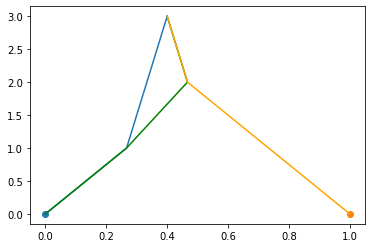

In [12]:
sigma_11 = [[2,1/2],[1/2,11/4]]

locs = np.array([0,1])

#plot sample locations
for loc in locs:
    plt.scatter(loc,0)

ts = np.linspace(0,3,100)
    
#plot leftmost ancestor locations
lAs = []
for t in ts:
    if t < 1: #when below node 2 (the loop)
        tA = 1 - t #length of branch from ancestor to node 2
        sigma_12 = [tA+1,1/2] #length of shared branch with sample 0 (tA) plus covariance of node 2's location with sample 0's location (1), covariance of node 3 and 4's locations (1/2) 
    else: #in the loop
        tA = 3 - t #length of branch from ancestor to node 5
        sigma_12 = [tA/2,tA/4] #tA(t3+t4)/(2t2),tAt4/(2t2)
    lAs.append(anc_locs(sigma_11, sigma_12, locs))
plt.plot(lAs, ts)

#plot center ancestor locations
lAs = []
for t in ts:
    if t < 1:
        tA = 1 - t
        sigma_12 = [tA+1,1/2]
    elif t < 2:
        tA = 2 - t
        sigma_12 = [(tA+1)/2,(2+1-tA)/4]
    else:
        tA = 3 - t
        sigma_12 = [tA/2,tA*3/4]
    lAs.append(anc_locs(sigma_11, sigma_12, locs))
plt.plot(lAs, ts, color="green")

#plot rightmost ancestor locations
lAs = []
for t in ts:
    if t < 2:
        tA = 2 - t
        sigma_12 = [1/2,tA+3/4]
    else:
        tA = 3 - t
        sigma_12 = [tA/2,tA*3/4]
    lAs.append(anc_locs(sigma_11, sigma_12, locs))
plt.plot(lAs, ts, color="orange")

plt.show()

And just flipping your plot around to compare with the same orientation

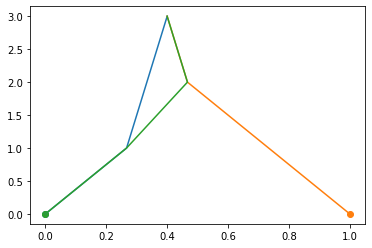

In [13]:
timeseries = pd.DataFrame(data=np.arange(3, -0.5, -0.5), columns=["t"]) #times since MRCA
timeseries = timeseries.apply(calc_cmvn, axis=1, cov_mat=ra, sample_locs=[[0],[1],[0]]) #expected ancestor locations over all times

for lineage in range(len(timeseries.columns)-1):
    plt.scatter(timeseries["A"+str(lineage)][0], 3-timeseries["t"][0]) #sample locations
    plt.plot(timeseries["A"+str(lineage)], 3-timeseries["t"]) #ancestor locations

plt.show()

So we do see a difference, though somewhat subtle in this example:

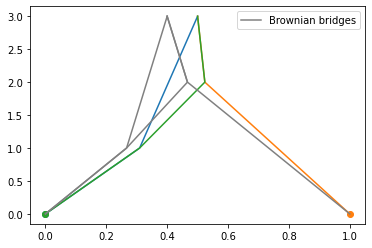

In [16]:
#yours
timeseries = pd.DataFrame(data=np.arange(3, -0.5, -0.5), columns=["t"]) #times since MRCA
timeseries = timeseries.apply(calc_cmvn, axis=1, cov_mat=ra, sample_locs=[[0],[1],[0]]) #expected ancestor locations over all times

for lineage in range(len(timeseries.columns)-1):
    plt.scatter(timeseries["A"+str(lineage)][0], 3-timeseries["t"][0]) #sample locations
    plt.plot(timeseries["A"+str(lineage)], 3-timeseries["t"]) #ancestor locations

#ours
sigma_11 = [[2,1/2],[1/2,11/4]]

ts = np.linspace(0,3,100)
    
#plot leftmost ancestor locations
l7s = []
for t in ts:
    if t < 1:
        t7 = 1 - t
        sigma_12 = [t7+1,1/2]
    else:
        t7 = 3 - t
        sigma_12 = [t7/2,t7/4]
    l7s.append(anc_locs(sigma_11, sigma_12, locs))
plt.plot(l7s, ts, color="gray")

#plot center ancestor locations
l7s = []
for t in ts:
    if t < 1:
        t7 = 1 - t
        sigma_12 = [t7+1,1/2]
    elif t < 2:
        t7 = 2 - t
        sigma_12 = [(t7+1)/2,(2+1-t7)/4]
    else:
        t7 = 3 - t
        sigma_12 = [t7/2,t7*3/4]
    l7s.append(anc_locs(sigma_11, sigma_12, locs))
plt.plot(l7s, ts, color="gray")

#plot rightmost ancestor locations
l7s = []
for t in ts:
    if t < 2:
        t7 = 2 - t
        sigma_12 = [1/2,t7+3/4]
    else:
        t7 = 3 - t
        sigma_12 = [t7/2,t7*3/4]
    l7s.append(anc_locs(sigma_11, sigma_12, locs))
plt.plot(l7s, ts, color="gray", label='Brownian bridges')
    
plt.legend()
plt.show()

Here we don't have the same k-1 factor, so not sure what is causing the difference. I feel like this is a real difference in method, though strange that our approaches give the same dispersal rate (with correction) and not ancestor locations! (Perhaps just coincidence.) Our method gives more covariance between the location of sample 0 and the locations of the ancestors. I think this is because we treat the loop explicitly, telling us, for example, that an ancestor between nodes 3 and 5 not has covariance with the location of node 0 through shared time along the green lineage, but also has covariance with the location of node 0 through covariance with the blue lineage, since we know the green and blue lineages meet in a recombination event in more recent time. It seems we should be taking that latter piece of info into account, no? I therefore think the Brownian bridge approach is the way to go.

# Simple Three Samples

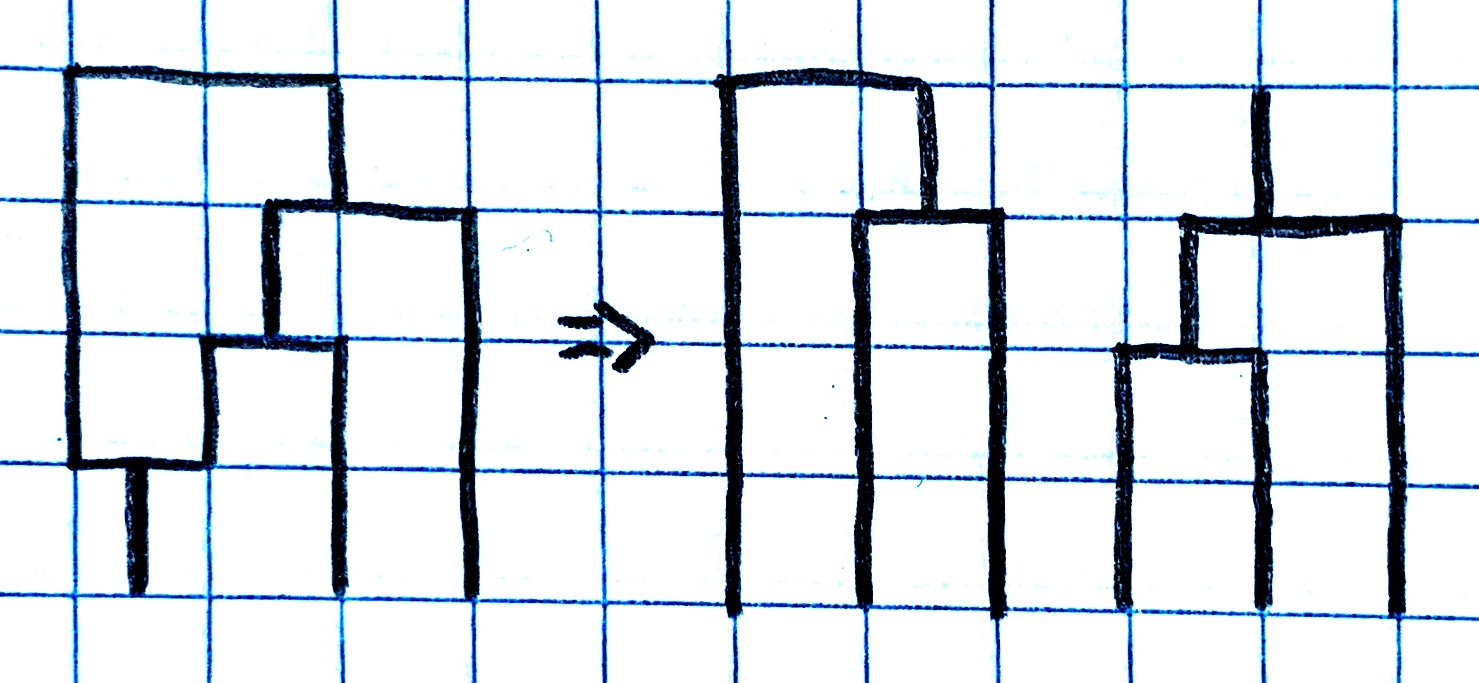

In [17]:
ra = np.array([
    [4,0,0,1,0,0],
    [0,4,1,2,4,1],
    [0,1,4,1,1,4],
    [1,2,1,4,2,1],
    [0,4,1,2,4,1],
    [0,1,4,1,1,4]
])
new_order = [0, 1, 2, 3]
ra = ra[:, new_order][new_order]

locations = np.array([
    [-4],
    [0],
    [4],
    [-4]
])

In [18]:
def cond_mvn(locations, mean_1, mean_2, sigma_11, sigma_22):
    u = mean_1 + np.dot(np.dot(sigma_11, np.linalg.inv(sigma_22)),locations - mean_2)
    sigma = sigma_11 - np.dot(np.dot(sigma_11, np.linalg.inv(sigma_22)), sigma_11)
    return u, sigma

def calc_cmvn(df, cov_mat, sample_locs):
    a = df["t"]
    if a > 3:
        b = a - 3
    else:
        b = 0
    if a < 1:
        c = a
    else:
        c = 1
    if a < 2:
        d = a
    else:
        d = 2
    sigma_11 = np.array([
        [a,0,0,b],
        [0,a,c,d],
        [0,c,a,c],
        [b,d,c,a]
    ])
    u1 = np.array([np.mean(sample_locs[0:3])])
    u2 = np.array([[np.mean(sample_locs[0:3])]]*cov_mat.shape[0])
    expectation, variance = cond_mvn(
        locations=sample_locs,
        sigma_11=sigma_11,
        sigma_22=cov_mat,
        mean_1=u1,
        mean_2=u2
    )
    positions = np.transpose(expectation)[0]
    for p in range(len(positions)):
        df["A"+str(p)] = positions[p]
    return df

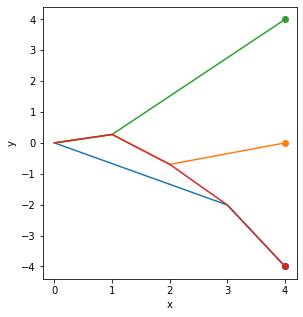

In [19]:
timeseries = pd.DataFrame(data=np.arange(4, -0.5, -0.5), columns=["t"])
timeseries = timeseries.apply(calc_cmvn, axis=1, cov_mat=ra, sample_locs=locations)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
for lineage in range(len(timeseries.columns)-1):
    ax1.scatter(timeseries["t"][0], timeseries["A"+str(lineage)][0])
    ax1.plot(timeseries["t"], timeseries["A"+str(lineage)])

ax1.set_xlabel('x')
ax1.set_ylabel('y')

plt.show()

OK, let's see how the dispersal rate esimates differ between our methods with this arg. 

My covariance matrix is

In [20]:
ra2 = [
 [1 + 3/2, 3/4, 1/2],
 [3/4, 2 + 4/3, 2/3],
 [1/2, 2/3, 3 + 5/6]
]

And my dispersal estimate is

In [21]:
disp2 = mle_dispersal(sigma_11=ra2, locs=np.array([0,1,2]))
disp2

array([0.38585209])

Your dispersal estimate is

In [22]:
disp = mle_dispersal(sigma_11=ra, locs=np.array([0,1,2,0]))
disp

array([0.26415094])

So perhaps the fact that your estimate was half ours in the first example was a fluke. And once again the Brownian bridge estimate is higher.

# Three Samples With Internal Loop

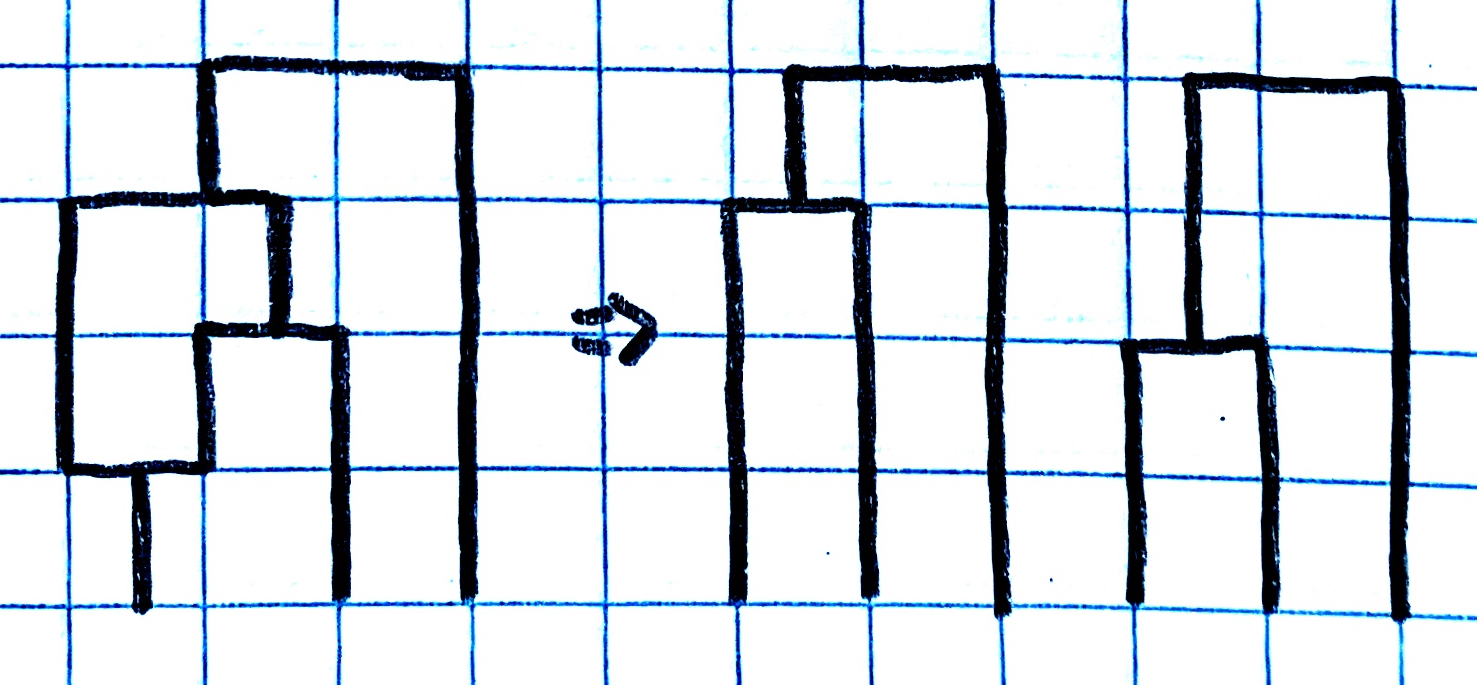

In [204]:
ra = np.array([
    [4,1,0,2,1,0],
    [1,4,0,2,4,0],
    [0,0,4,0,0,4],
    [2,2,0,4,2,0],
    [1,4,0,2,4,0],
    [0,0,4,0,0,4]
])
new_order = [0, 1, 2, 3]
ra = ra[:, new_order][new_order]

locations = np.array([
    [-4],
    [0],
    [4],
    [-4]
])

In [205]:
def cond_mvn(locations, mean_1, mean_2, sigma_11, sigma_22):
    u = mean_1 + np.dot(np.dot(sigma_11, np.linalg.inv(sigma_22)),locations - mean_2)
    sigma = sigma_11 - np.dot(np.dot(sigma_11, np.linalg.inv(sigma_22)), sigma_11)
    return u, sigma

def calc_cmvn(df, cov_mat, sample_locs):
    a = df["t"]
    if a < 1:
        b = a
    else:
        b = 1
    if a > 3:
        c = a - 3 + b
    else:
        c = b
    if a < 2:
        d = a
    else:
        d = 2
    sigma_11 = np.array([
        [a,b,0,c],
        [b,a,0,d],
        [0,0,a,0],
        [c,d,0,a]
    ])
    u1 = np.array([np.mean(sample_locs[0:3])])
    u2 = np.array([[np.mean(sample_locs[0:3])]]*cov_mat.shape[0])
    expectation, variance = cond_mvn(
        locations=sample_locs,
        sigma_11=sigma_11,
        sigma_22=cov_mat,
        mean_1=u1,
        mean_2=u2
    )
    positions = np.transpose(expectation)[0]
    for p in range(len(positions)):
        df["A"+str(p)] = positions[p]
    return df

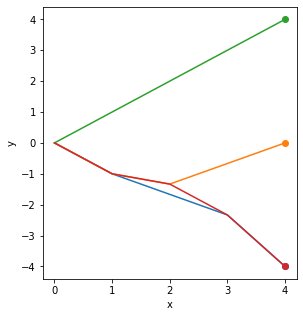

In [206]:
timeseries = pd.DataFrame(data=np.arange(4, -0.5, -0.5), columns=["t"])
timeseries = timeseries.apply(calc_cmvn, axis=1, cov_mat=ra, sample_locs=locations)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
for lineage in range(len(timeseries.columns)-1):
    ax1.scatter(timeseries["t"][0], timeseries["A"+str(lineage)][0])
    ax1.plot(timeseries["t"], timeseries["A"+str(lineage)])

ax1.set_xlabel('x')
ax1.set_ylabel('y')

plt.show()

# Three Samples With Split After Recombination

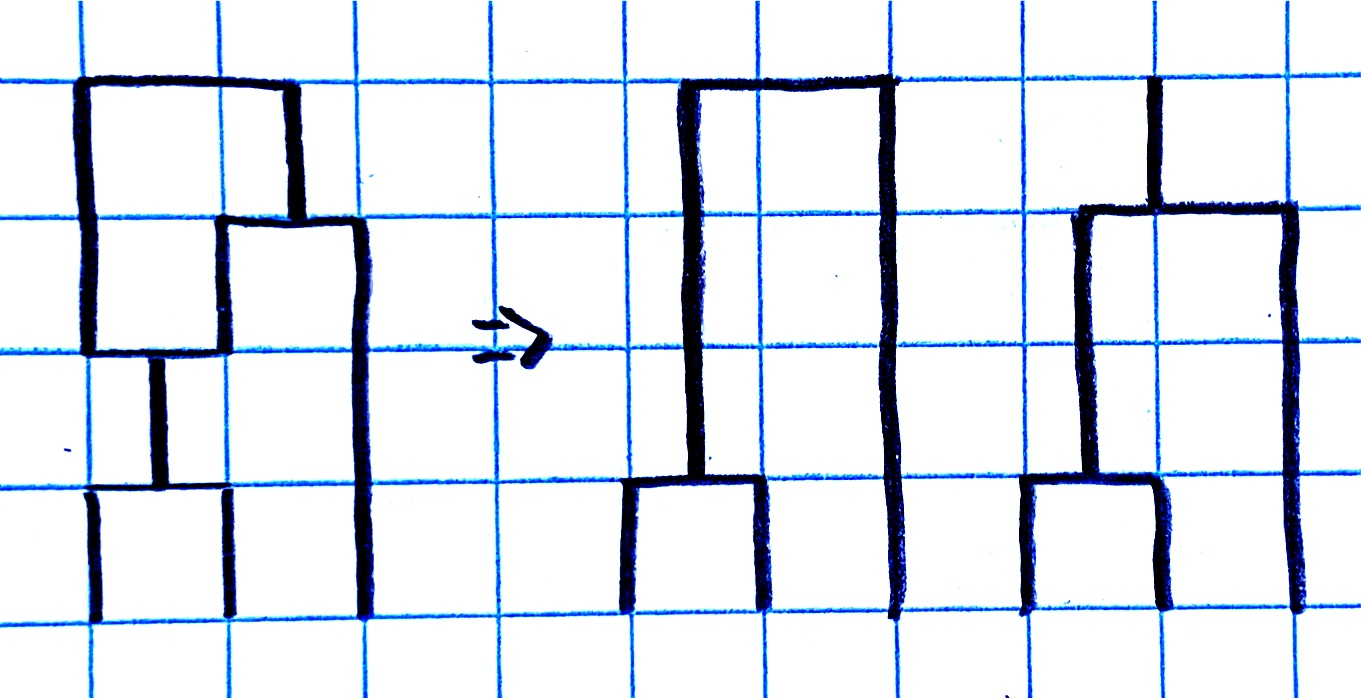

This one is very interesting because it is a singular matrix which fails in the conditional multivariate normal function because it doesn't have an inverse. To avoid this, I changed one value (position 1,5) in the matrix slightly. This is obviously not ideal, so need to find another way...

In [228]:
ra = np.array([
    [4,3,0,2,1,0],
    [3,4,0,1,2,0],
    [0,0,4,1,1,4],
    [2,1,1,4,3,1],
    [1,2,1,3,4,1],
    [0,0,4,1,1,4]
])
new_order = [0, 1, 2, 3, 4]
ra = ra[:, new_order][new_order]

locations = np.array([
    [-4],
    [0],
    [4],
    [-4],
    [0]
])


In [229]:
def cond_mvn(locations, mean_1, mean_2, sigma_11, sigma_22):
    u = mean_1 + np.dot(np.dot(sigma_11, np.linalg.inv(sigma_22)),locations - mean_2)
    sigma = sigma_11 - np.dot(np.dot(sigma_11, np.linalg.inv(sigma_22)), sigma_11)
    return u, sigma

def calc_cmvn(df, cov_mat, sample_locs):
    a = df["t"]
    if a < 3:
        b = a
    else:
        b = 3
    if a > 2:
        c = a - 2
        if a < 3:
            d = a - 2
        else:
            d = 3 - 2
    else:
        c = 0
        d = 0
    if a < 1:
        e = a
    else:
        e = 1
    sigma_11 = np.array([
        [a,b,0,c,d],
        [b,a,0,d,c],
        [0,0,a,e,e],
        [c,d,e,a,b],
        [d,c,e,b,a]
    ])
    u1 = np.array([np.mean(sample_locs[0:3])])
    u2 = np.array([[np.mean(sample_locs[0:3])]]*cov_mat.shape[0])
    expectation, variance = cond_mvn(
        locations=sample_locs,
        sigma_11=sigma_11,
        sigma_22=cov_mat,
        mean_1=u1,
        mean_2=u2
    )
    positions = np.transpose(expectation)[0]
    for p in range(len(positions)):
        df["A"+str(p)] = positions[p]
    return df

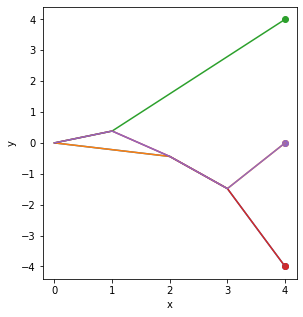

In [230]:
timeseries = pd.DataFrame(data=np.arange(4, -0.5, -0.5), columns=["t"])
timeseries = timeseries.apply(calc_cmvn, axis=1, cov_mat=ra, sample_locs=locations)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
for lineage in range(len(timeseries.columns)-1):
    ax1.scatter(timeseries["t"][0], timeseries["A"+str(lineage)][0])
    ax1.plot(timeseries["t"], timeseries["A"+str(lineage)])

ax1.set_xlabel('x')
ax1.set_ylabel('y')

plt.show()

# Four Samples With Internal Loop and Split After Recombination

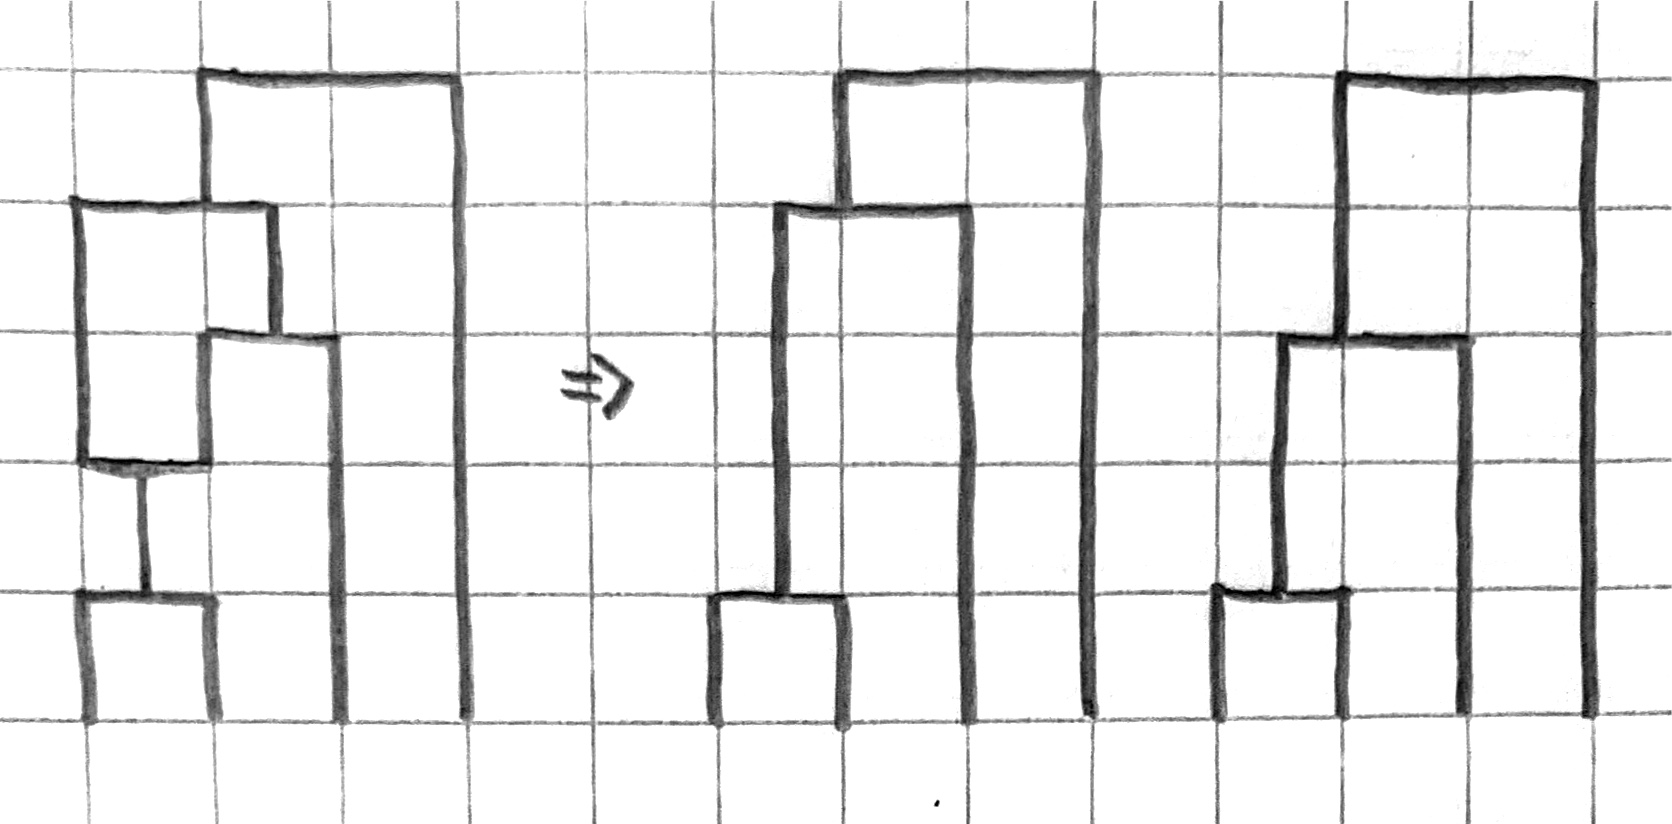

In [340]:
ra = np.array([
    [5,4,1,0,3,1.9,1,0],
    [4,5,1,0,2,3,1,0],
    [1,1,5,0,2,2,5,0],
    [0,0,0,5,0,0,0,5],
    [3,2,2,0,5,4,2,0],
    [2,3,2,0,4,5,2,0],
    [1,1,5,0,2,2,5,0],
    [0,0,0,5,0,0,0,5]
])
new_order = [0, 1, 2, 3, 4, 5]
ra = ra[:, new_order][new_order]

locations = np.array([
    [-4],
    [-1],
    [1],
    [4],
    [-4],
    [-1]
])

ra

array([[5. , 4. , 1. , 0. , 3. , 1.9],
       [4. , 5. , 1. , 0. , 2. , 3. ],
       [1. , 1. , 5. , 0. , 2. , 2. ],
       [0. , 0. , 0. , 5. , 0. , 0. ],
       [3. , 2. , 2. , 0. , 5. , 4. ],
       [2. , 3. , 2. , 0. , 4. , 5. ]])

In [279]:
def cond_mvn(locations, mean_1, mean_2, sigma_11, sigma_22):
    u = mean_1 + np.dot(np.dot(sigma_11, np.linalg.inv(sigma_22)),locations - mean_2)
    sigma = sigma_11 - np.dot(np.dot(sigma_11, np.linalg.inv(sigma_22)), sigma_11)
    return u, sigma

def calc_cmvn(df, cov_mat, sample_locs):
    a = df["t"]
    if a < 4:
        b = a
    else:
        b = 4
    if a < 1:
        c = a
    else:
        c = 1
    if a > 3:
        d = a - 3 + c
        if a < 4:
            e = a - 3 + c
        else:
            e = 1 + c
    else:
        d = c
        e = c
    if a < 2:
        f = a
    else:
        f = 2
    sigma_11 = np.array([
        [a,b,c,0,d,e],
        [b,a,c,0,e,d],
        [c,c,a,0,f,f],
        [0,0,0,a,0,0],
        [d,e,f,0,a,b],
        [e,d,f,0,b,a]
    ])
    u1 = np.array([np.mean(sample_locs[0:4])])
    u2 = np.array([[np.mean(sample_locs[0:4])]]*cov_mat.shape[0])
    expectation, variance = cond_mvn(
        locations=sample_locs,
        sigma_11=sigma_11,
        sigma_22=cov_mat,
        mean_1=u1,
        mean_2=u2
    )
    positions = np.transpose(expectation)[0]
    for p in range(len(positions)):
        df["A"+str(p)] = positions[p]
    return df

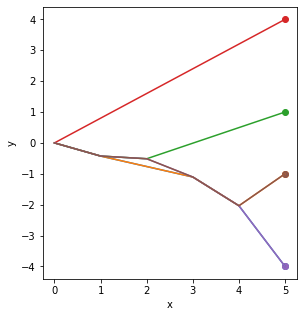

In [280]:
timeseries = pd.DataFrame(data=np.arange(5, -0.5, -0.5), columns=["t"])
timeseries = timeseries.apply(calc_cmvn, axis=1, cov_mat=ra, sample_locs=locations)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
for lineage in range(len(timeseries.columns)-1):
    ax1.scatter(timeseries["t"][0], timeseries["A"+str(lineage)][0])
    ax1.plot(timeseries["t"], timeseries["A"+str(lineage)])

ax1.set_xlabel('x')
ax1.set_ylabel('y')

plt.show()

# some old code of mine that makes the same covariance as you

In [30]:
import random
from collections import defaultdict
from itertools import chain
import networkx as nx

In [54]:
def compare(sample_size=3, Ne=1e3, length=1e4, recombination_rate=1e-8, random_seed=1):

    #ARG
    ts = msprime.simulate(sample_size=sample_size, Ne=Ne, length=length, recombination_rate=recombination_rate, random_seed=random_seed, record_full_arg=True)
    
    # print tree sequence
    print('\nthe trees are:')
    for tree in ts.trees():
        print(tree.draw(format='ascii'))
        
    print('node times')
    [print(i.id,i.time) for i in ts.nodes()]

    # make the (incomplete) ARG
    topology = defaultdict(list)
    for tree in ts.trees():
        for k, v in chain(tree.parent_dict.items()):
            if v not in topology[k]:
                topology[k].append(v)
    G = nx.DiGraph(dict(topology))
#     print('the (incomplete) ARG:')
#     nx.draw(G, with_labels=True, font_weight='bold', pos=nx.circular_layout(G))

    #unique paths up the ARG
    gmrca = ts.node(ts.num_nodes-1).id
    all_paths = []
    for sample in ts.samples():
        paths = nx.all_simple_paths(G, source=sample, target=gmrca)
        all_paths.extend(paths)
    print('\nthe unique paths from the samples to the GMRCA are:')
    print(all_paths)

    #shared times
    tgmrca = ts.node(gmrca).time
    tmrcas = np.empty((len(all_paths),len(all_paths)))
    tree = ts.first()
    for i, p in enumerate(all_paths):
        for j in range(i+1):
            intersect = list(set(p).intersection(all_paths[j]))
            if i == j:
                tmrcas[i,j] = 0
            elif intersect == [gmrca]:
                    tmrcas[i,j] = tgmrca
            else:
                edges = []
                for k in ts.edges():
                    if k.child in intersect:
                        edges.append(ts.node(k.parent).time - ts.node(k.child).time)
                tmrcas[i,j] = tgmrca - np.sum(np.unique(edges))
            tmrcas[j,i] = tmrcas[i,j]
    times = tgmrca - tmrcas
    print('\nthe shared times between the unique paths are:')
    print(times)

    # locations
    locs = np.array([i for i in range(sample_size)]) #arrange samples at integer locations
    k = len(times) #number of paths
    idx = [i[0] for i in all_paths] #sample at start of each path
    x = locs[idx].reshape(-1,1) #starting locations of each path

    # estimate location of GMRCA and dispersal rate
    Tinv = np.linalg.pinv(times) #generalized inverse of covariance matrix
    a1 = np.matmul( np.matmul(np.ones(k), Tinv), np.ones(k).reshape(-1,1))
    a2 = np.matmul( np.matmul(np.ones(k), Tinv), x)
    ahat = a2/a1 #eqn 5.6 Harmon book
    print('\nthe GMRCA location and dispersal rate estimates from this covariance matrix are:')

    R1 = x - ahat * np.ones(k).reshape(-1,1)
    Rhat = np.matmul(np.matmul(np.transpose(R1), Tinv), R1) / (k-1) #eqn 5.7 Harmon book
    print(ahat,Rhat)

In [55]:
compare(sample_size=2, random_seed=1)


the trees are:
 5 
+++
| 4
| |
2 |
| |
0 1

 4 
+++
3 |
| |
0 1

node times
0 0.0
1 0.0
2 2698.0291325593153
3 2698.0291325593153
4 2698.1053909743205
5 3015.524585426889

the unique paths from the samples to the GMRCA are:
[[0, 2, 5], [0, 3, 4, 5], [1, 4, 5]]

the shared times between the unique paths are:
[[3015.52458543 2698.02913256    0.        ]
 [2698.02913256 3015.52458543  317.41919445]
 [   0.          317.41919445 3015.52458543]]

the GMRCA location and dispersal rate estimates from this covariance matrix are:
[0.49999293] [[9.26576112e-05]]
